# Entregable 2: Comparación de distintos espacios de color en imágenes digitales

Este proyecto presenta un análisis completo de diferentes espacios de color y sus aplicaciones prácticas en visión por ordenador.

Las imágenes utilizadas en los experimentos se generan automáticamente en la carpeta `data/` si no existían posteriormente:
- **Imágenes**: 
  - `gradiente_rgb.png` - Gradientes de colores primarios
  - `colores_saturados.png` - Colores puros
  - `espectro_hsv.png` - Espectro completo HSV (Hue horizontal, Saturación vertical)
  - `tonos_piel.png` - Tonos de piel para detección YCrCb
  - `formas_geometricas.png` - Formas variadas para detección de bordes

## Espacios de Color a Analizar
1. **RGB**
2. **HSV**   
3. **CIELAB (Lab)** 
4. **YCrCb**
5. **Escala de Grises** 
6. **XYZ** 

In [1]:
# Importación de librerías necesarias
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import os

print("Librerías importadas correctamente")

Librerías importadas correctamente


Cargada imagen existente: gradiente
Cargada imagen existente: colores
Cargada imagen existente: espectro_hsv
Cargada imagen existente: piel
Cargada imagen existente: formas


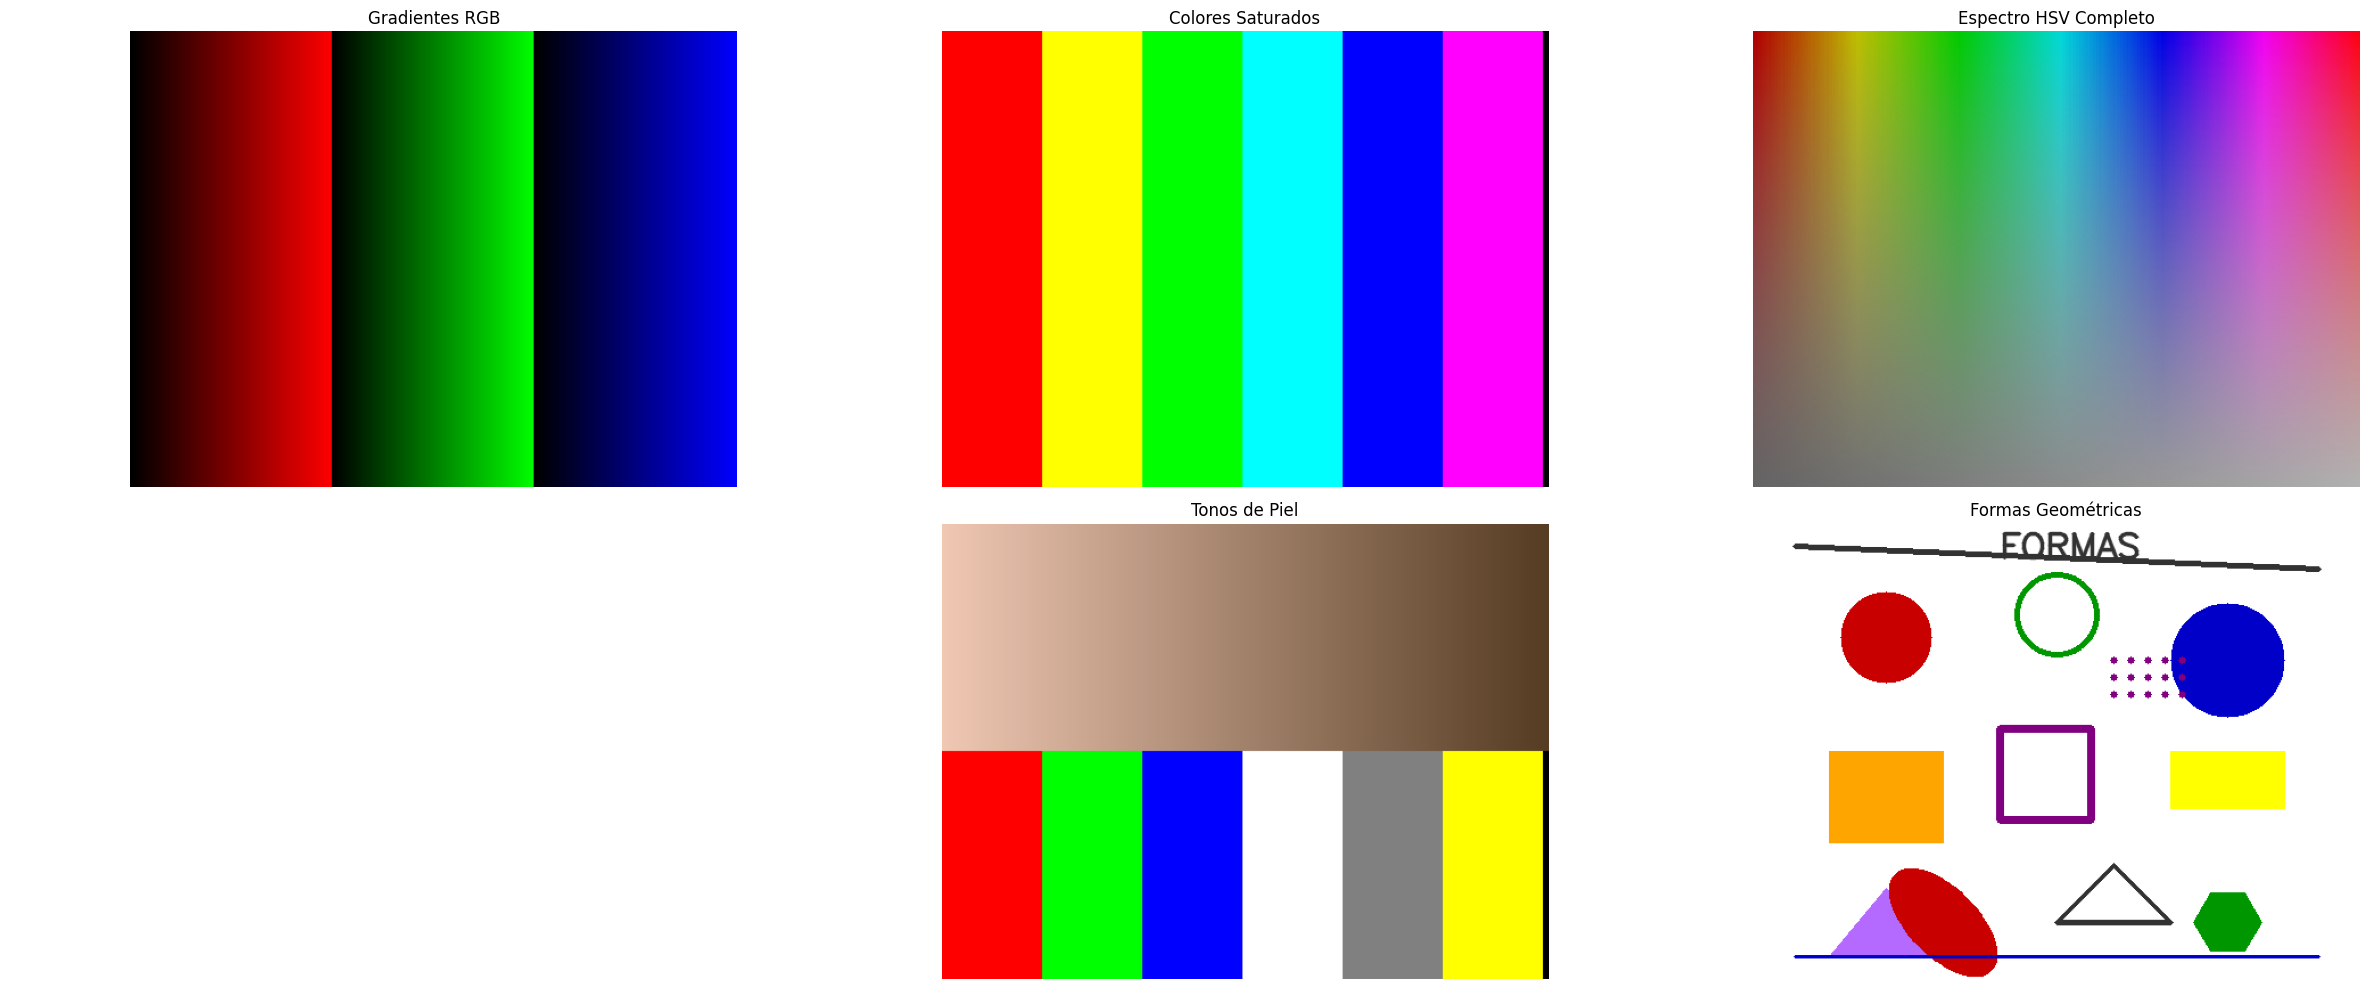

In [16]:
# Gestión de imágenes de prueba - Creación y carga desde data/

def crear_imagen_gradiente_rgb():
    """Crea una imagen con gradientes de colores RGB"""
    altura, ancho = 300, 400
    imagen = np.zeros((altura, ancho, 3), dtype=np.uint8)
    #Las imágenes en OpenCV usan el formato BGR en lugar de RGB

        # Gradiente horizontal de rojo
    for x in range(ancho//3):
        imagen[:300, x] = [0, 0, int(255 * x / (ancho//3))]

    # Gradiente horizontal de verde
    for x in range(ancho//3, 2*ancho//3):
        imagen[:300, x] = [0, int(255 * (x - ancho//3) / (ancho//3)), 0]

    # Gradiente horizontal de azul
    for x in range(2*ancho//3, ancho):
        imagen[:300, x] = [int(255 * (x - 2*ancho//3) / (ancho//3)), 0, 0]

    return imagen

def crear_imagen_colores_saturados():
    """Crea una imagen con colores saturados para análisis HSV"""
    altura, ancho = 300, 400
    imagen = np.zeros((altura, ancho, 3), dtype=np.uint8)
    
     # Colores en formato BGR (Blue, Green, Red)
    colores = [
        [0, 0, 255],      # Rojo en BGR
        [0, 255, 255],    # Amarillo en BGR  
        [0, 255, 0],      # Verde en BGR
        [255, 255, 0],    # Cian en BGR
        [255, 0, 0],      # Azul en BGR
        [255, 0, 255]     # Magenta en BGR
    ]
    
    ancho_banda = ancho // len(colores)
    for i, color in enumerate(colores):
        x_inicio = i * ancho_banda
        x_fin = min((i + 1) * ancho_banda, ancho)
        imagen[:, x_inicio:x_fin] = color
    
    return imagen

def crear_imagen_espectro_hsv():
    altura, ancho = 300, 400
    imagen = np.zeros((altura, ancho, 3), dtype=np.uint8)
    
    # Crear espectro HSV completo con variación en los tres canales
    for y in range(altura):
        for x in range(ancho):
            # Calcular valores HSV
            # Hue: varía horizontalmente de 0 a 179 (rango OpenCV)
            h = int((x / ancho) * 179)
            
            # Saturation: varía verticalmente de 255 (arriba) a 0 (abajo)
            s = int(255 * (1 - y / altura))
            
            # Esquina superior izquierda: V máximo (255)
            # Esquina inferior derecha: V mínimo (pero no negro total)
            factor_diagonal = (x / ancho + (1 - y / altura)) / 2
            v = int(100 + 155 * factor_diagonal)  # Rango: 100-255 para mantener visibilidad
            
            # Crear pixel HSV y convertir a BGR
            hsv_pixel = np.array([[[h, s, v]]], dtype=np.uint8)
            bgr_pixel = cv2.cvtColor(hsv_pixel, cv2.COLOR_HSV2BGR)
            imagen[y, x] = bgr_pixel[0, 0]
    
    return imagen

def crear_imagen_con_piel():
    """Crea una imagen con tonos de piel y colores puros"""
    altura, ancho = 300, 400
    imagen = np.zeros((altura, ancho, 3), dtype=np.uint8)
    
    # Definir tonos de piel extremos para el gradiente (valores BGR)
    piel_clara = np.array([180, 200, 240], dtype=np.float32)    # Piel muy clara (rosada)
    piel_oscura = np.array([35, 60, 85], dtype=np.float32)     # Piel muy oscura
    
    # Crear gradiente horizontal de tonos de piel
    for x in range(ancho):
        # Calcular factor de interpolación (0.0 a 1.0)
        factor = x / (ancho - 1)
        
        # Interpolar entre piel clara y oscura
        color_piel = piel_clara * (1 - factor) + piel_oscura * factor
        
        # Asignar color a la mitad superior de la imagen
        imagen[:altura//2, x] = color_piel.astype(np.uint8)
    
    # Añadir otros colores para comparación (parte inferior)
    otros_colores = [
        [0, 0, 255],        # Rojo
        [0, 255, 0],        # Verde  
        [255, 0, 0],        # Azul
        [255, 255, 255],    # Blanco
        [128, 128, 128],    # Gris
        [0, 255, 255],      # Amarillo
    ]
    
    seccion_ancho = ancho // len(otros_colores)
    
    # Añadir otros colores en la parte inferior
    for i, color in enumerate(otros_colores):
        x_inicio = i * seccion_ancho
        x_fin = min((i + 1) * seccion_ancho, ancho)
        imagen[altura//2:, x_inicio:x_fin] = color
    
    return imagen

# Añadir esta función después de crear_imagen_con_piel()

def crear_imagen_formas_geometricas():
    """Crea una imagen con formas geométricas variadas para detección de bordes"""
    altura, ancho = 400, 500
    imagen = np.ones((altura, ancho, 3), dtype=np.uint8) * 255  # Fondo blanco
    
    # Colores variados en formato BGR
    colores = [
        [0, 0, 200],      # Rojo oscuro
        [0, 150, 0],      # Verde oscuro  
        [200, 0, 0],      # Azul oscuro
        [0, 165, 255],    # Naranja
        [128, 0, 128],    # Púrpura
        [0, 255, 255],    # Amarillo
        [255, 105, 180],  # Rosa
        [50, 50, 50],     # Gris oscuro
    ]
    
    # Círculos de diferentes tamaños
    cv2.circle(imagen, (100, 100), 40, colores[0], -1)  # Círculo rojo sólido
    cv2.circle(imagen, (250, 80), 35, colores[1], 3)    # Círculo verde hueco
    cv2.circle(imagen, (400, 120), 50, colores[2], -1)  # Círculo azul sólido
    
    # Rectángulos y cuadrados
    cv2.rectangle(imagen, (50, 200), (150, 280), colores[3], -1)    # Rectángulo naranja sólido
    cv2.rectangle(imagen, (200, 180), (280, 260), colores[4], 5)    # Cuadrado púrpura hueco
    cv2.rectangle(imagen, (350, 200), (450, 250), colores[5], -1)   # Rectángulo amarillo sólido
    
    # Triángulos usando polígonos
    triangulo1 = np.array([[100, 320], [150, 380], [50, 380]], np.int32)
    cv2.fillPoly(imagen, [triangulo1], colores[6])  # Triángulo rosa sólido
    
    triangulo2 = np.array([[300, 300], [350, 350], [250, 350]], np.int32)
    cv2.polylines(imagen, [triangulo2], True, colores[7], 4)  # Triángulo gris hueco
    
    # Formas más complejas
    # Hexágono
    hex_center = (400, 350)
    hex_radius = 30
    hex_points = []
    for i in range(6):
        angle = i * np.pi / 3
        x = int(hex_center[0] + hex_radius * np.cos(angle))
        y = int(hex_center[1] + hex_radius * np.sin(angle))
        hex_points.append([x, y])
    hex_points = np.array(hex_points, np.int32)
    cv2.fillPoly(imagen, [hex_points], colores[1])  # Hexágono verde
    
    # Elipse
    cv2.ellipse(imagen, (150, 350), (60, 30), 45, 0, 360, colores[0], -1)  # Elipse roja
    
    # Líneas y formas lineales
    cv2.line(imagen, (20, 20), (480, 40), colores[7], 3)           # Línea diagonal
    cv2.line(imagen, (20, 380), (480, 380), colores[2], 2)         # Línea horizontal
    
    # Agregar algo de texto para hacer más interesante la detección
    cv2.putText(imagen, 'FORMAS', (200, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                1, colores[7], 2, cv2.LINE_AA)
    
    # Añadir algunos patrones de puntos
    for i in range(5):
        for j in range(3):
            cv2.circle(imagen, (300 + i*15, 120 + j*15), 3, colores[4], -1)
    
    return imagen

def cargar_o_crear_imagenes():
    """Carga las imágenes desde data/ o las crea si no existen"""
    # Crear directorio data si no existe
    data_dir = 'data'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        print(f"Directorio '{data_dir}' creado")
    
    # Rutas de las imágenes
    rutas = {
        'gradiente': os.path.join(data_dir, 'gradiente_rgb.png'),
        'colores': os.path.join(data_dir, 'colores_saturados.png'),
        'espectro_hsv': os.path.join(data_dir, 'espectro_hsv.png'),
        'piel': os.path.join(data_dir, 'tonos_piel.png'),
        'formas': os.path.join(data_dir, 'formas_geometricas.png')
    }
    
    imagenes = {}
    
    # Cargar o crear cada imagen
    for nombre, ruta in rutas.items():
        if os.path.exists(ruta):
            imagenes[nombre] = cv2.imread(ruta)
            print(f"Cargada imagen existente: {nombre}")
        else:
            # Crear imagen sintética
            if nombre == 'gradiente':
                imagenes[nombre] = crear_imagen_gradiente_rgb()
            elif nombre == 'colores':
                imagenes[nombre] = crear_imagen_colores_saturados()
            elif nombre == 'espectro_hsv':
                imagenes[nombre] = crear_imagen_espectro_hsv()
            elif nombre == 'piel':
                imagenes[nombre] = crear_imagen_con_piel()
            elif nombre == 'formas': 
                imagenes[nombre] = crear_imagen_formas_geometricas()
            
            # Guardar imagen
            cv2.imwrite(ruta, imagenes[nombre])
            print(f"Creada y guardada nueva imagen: {nombre}")

    return imagenes['gradiente'], imagenes['colores'], imagenes['espectro_hsv'], imagenes['piel'], imagenes['formas']

# Cargar o crear las imágenes de prueba
img_gradiente, img_colores, img_espectro_hsv, img_piel, img_formas = cargar_o_crear_imagenes()

# Mostrar las imágenes cargadas/creadas
fig, axes = plt.subplots(2, 3, figsize=(25, 10))

axes[0, 0].imshow(cv2.cvtColor(img_gradiente, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Gradientes RGB')
axes[0, 0].axis('off')

axes[0, 1].imshow(cv2.cvtColor(img_colores, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title('Colores Saturados')
axes[0, 1].axis('off')

axes[0, 2].imshow(cv2.cvtColor(img_espectro_hsv, cv2.COLOR_BGR2RGB))
axes[0, 2].set_title('Espectro HSV Completo')
axes[0, 2].axis('off')

axes[1, 0].axis('off')

axes[1, 1].imshow(cv2.cvtColor(img_piel, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title('Tonos de Piel')
axes[1, 1].axis('off')

axes[1, 2].imshow(cv2.cvtColor(img_formas, cv2.COLOR_BGR2RGB))
axes[1, 2].set_title('Formas Geométricas')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## 1. Espacio de Color RGB (Red, Green, Blue)

### Características
- Los colores se forman sumando intensidades de rojo, verde y azul
- Cada canal tiene valores de 0-255 (8 bits)

### Experimento 1: Separación y Visualización de Canales RGB

Utilizamos la imagen de **gradientes RGB** porque:
- Cada sección contiene principalmente un color primario (rojo, verde, azul)
- Los gradientes muestran cómo cambia la intensidad de cada canal de 0 a 255

Separaremos los canales R, G, B de la imagen y los visualizaremos tanto en escala de grises (para ver la contribución individual) como en color (para ver el efecto visual de cada canal).

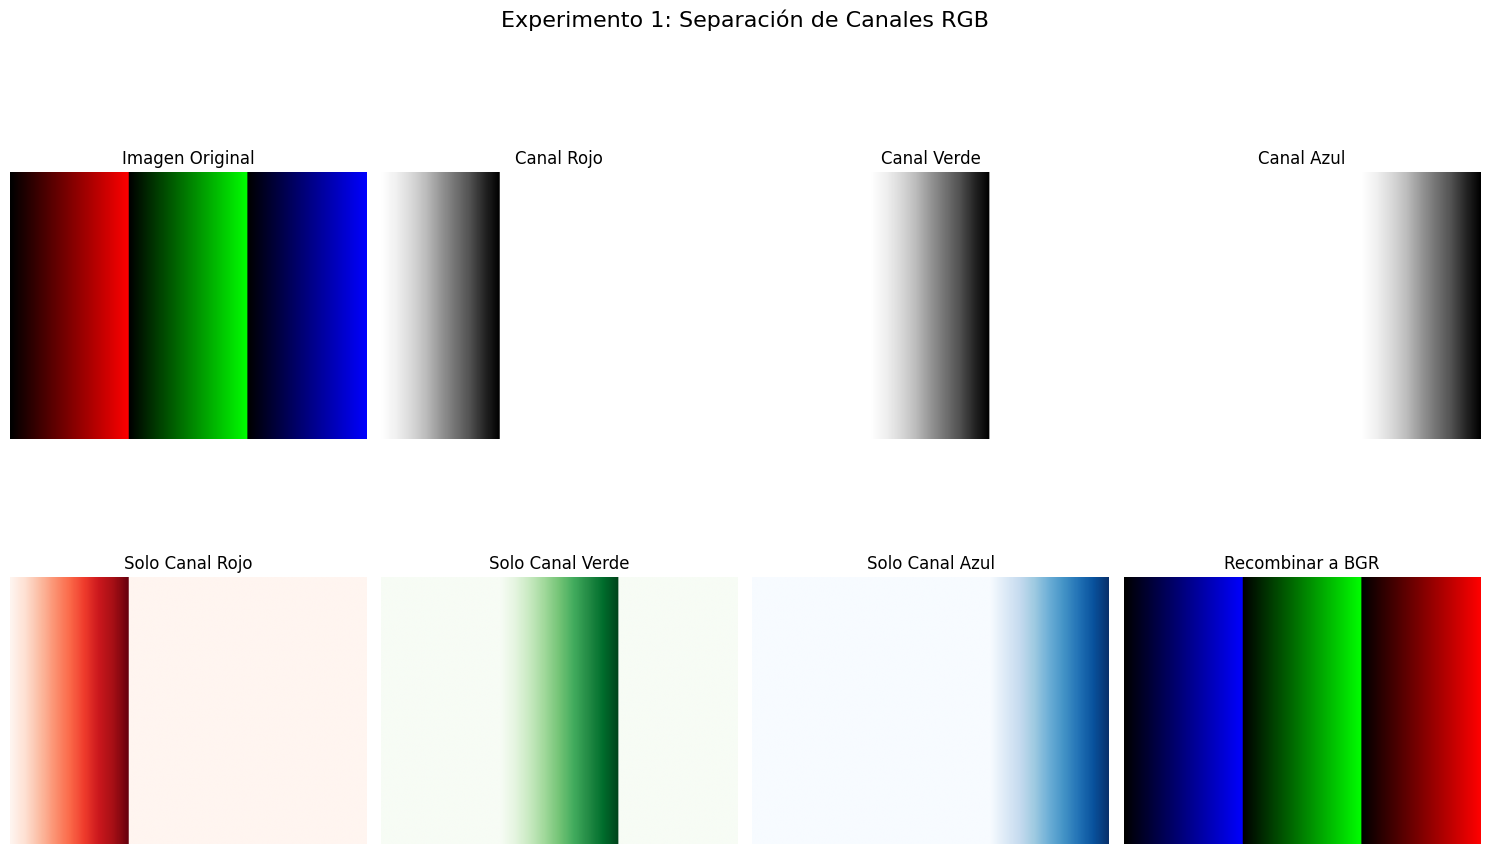

In [3]:
r,g,b = cv2.split(cv2.cvtColor(img_gradiente, cv2.COLOR_BGR2RGB))

# Visualizar análisis RGB - Separación de canales
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

# Imagen original
axes[0,0].imshow(cv2.cvtColor(img_gradiente, cv2.COLOR_BGR2RGB))
axes[0,0].set_title('Imagen Original')
axes[0,0].axis('off')

# Canales individuales en escala de grises
axes[0,1].imshow(r, cmap='Greys')
axes[0,1].set_title('Canal Rojo')
axes[0,1].axis('off')

axes[0,2].imshow(g, cmap='Greys')
axes[0,2].set_title('Canal Verde')
axes[0,2].axis('off')

axes[0,3].imshow(b, cmap='Greys')
axes[0,3].set_title('Canal Azul')
axes[0,3].axis('off')


# Canales individuales de color
axes[1,0].imshow(r, cmap='Reds')
axes[1,0].set_title('Solo Canal Rojo')
axes[1,0].axis('off')

axes[1,1].imshow(g, cmap='Greens')
axes[1,1].set_title('Solo Canal Verde')
axes[1,1].axis('off')

axes[1,2].imshow(b, cmap='Blues')
axes[1,2].set_title('Solo Canal Azul')
axes[1,2].axis('off')

# Reorganización de colores a bgr
axes[1,3].imshow(img_gradiente)
axes[1,3].set_title('Recombinar a BGR')
axes[1,3].axis('off')

plt.suptitle('Experimento 1: Separación de Canales RGB', fontsize=16)
plt.tight_layout()
plt.show()


### Experimento 2: Análisis de Histogramas RGB

Visualizaremos los histogramas de cada canal RGB para entender la distribución estadística de los valores de color.

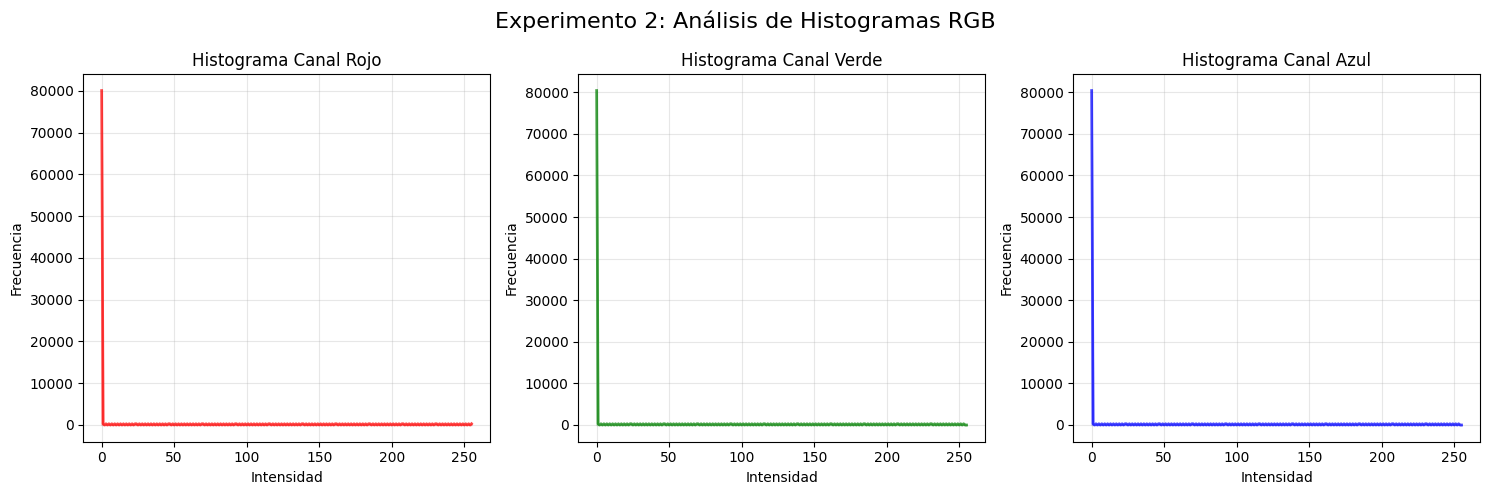

In [4]:
def analizar_histogramas_rgb(imagen):
    """Calcula y analiza los histogramas de cada canal RGB"""
    b, g, r = cv2.split(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    
    # Calcular histogramas
    hist_r = cv2.calcHist([r], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([g], [0], None, [256], [0, 256])
    hist_b = cv2.calcHist([b], [0], None, [256], [0, 256])
    
    return hist_r, hist_g, hist_b, r, g, b

# Calcular histogramas
hist_r, hist_g, hist_b, r, g, b = analizar_histogramas_rgb(img_gradiente)

# Visualizar histogramas RGB
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(hist_r, color='red', alpha=0.7, linewidth=2)
axes[0].fill_between(range(256), hist_r.flatten(), alpha=0.3, color='red')
axes[0].set_title('Histograma Canal Rojo')
axes[0].set_xlabel('Intensidad')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(True, alpha=0.3)

axes[1].plot(hist_g, color='green', alpha=0.7, linewidth=2)
axes[1].fill_between(range(256), hist_g.flatten(), alpha=0.3, color='green')
axes[1].set_title('Histograma Canal Verde')
axes[1].set_xlabel('Intensidad')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(True, alpha=0.3)

axes[2].plot(hist_b, color='blue', alpha=0.7, linewidth=2)
axes[2].fill_between(range(256), hist_b.flatten(), alpha=0.3, color='blue')
axes[2].set_title('Histograma Canal Azul')
axes[2].set_xlabel('Intensidad')
axes[2].set_ylabel('Frecuencia')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Experimento 2: Análisis de Histogramas RGB', fontsize=16)
plt.tight_layout()
plt.show()


## 2. Espacio de Color HSV (Hue, Saturation, Value)

### Características
- **H (Hue/Matiz)**: Tipo de color, rango 0-179° en OpenCV
- **S (Saturation/Saturación)**: Pureza del color, rango 0-255
- **V (Value/Valor)**: Brillo/luminosidad, rango 0-255
- **Separación**: Separa información de color (H,S) de luminosidad (V)

HSV separa la información cromática (H, S) de la luminosidad (V), lo que lo hace superior a RGB para:
- Segmentación robusta por color bajo diferentes condiciones de iluminación
- Detección de objetos basada en color
- Aplicaciones donde el color es más importante que el brillo


Utilizamos dos imágenes para los experimentos:

1. **Colores saturados**:
   - Podemos segmentar los colores facilmente definiuendo rangos por Hue
   - Permite ver claramente el canal de saturación en su máximo valor
   - Al tener brillo uniforme, se puede aislar el efecto de H y S

2. **Espectro HSV completo**: Muestra todo el espacio HSV.


### Experimento 1: Separación de canales.

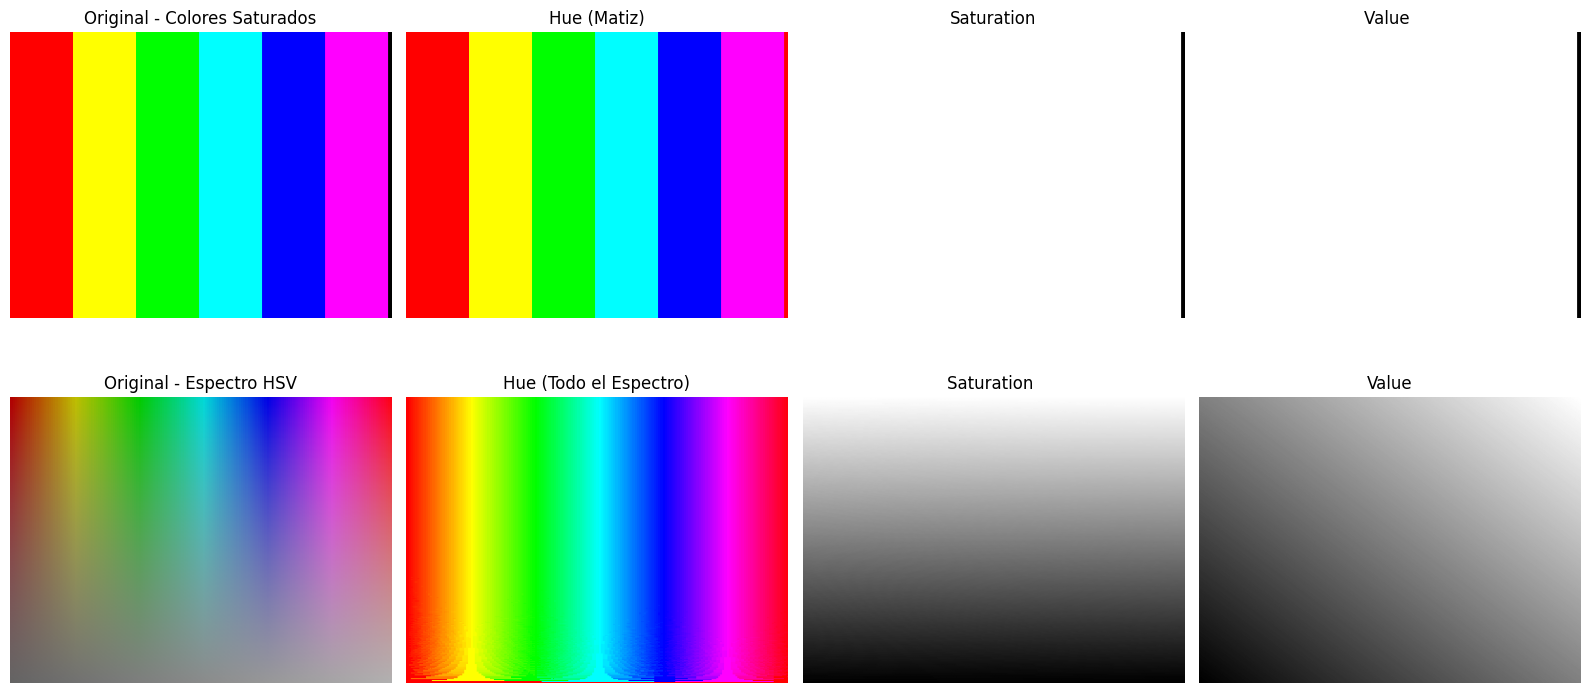

In [5]:
def analizar_hsv(imagen):
    """Convierte imagen a HSV y analiza sus canales"""
    # Convertir de BGR a HSV
    hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    
    # Separar canales
    h, s, v = cv2.split(hsv)
    
    return hsv, h, s, v

def visualizar_hue_correctamente(canal_h):
    altura, ancho = canal_h.shape
    hsv_visual = np.zeros((altura, ancho, 3), dtype=np.uint8)
    hsv_visual[:,:,0] = canal_h  # Hue original (0-179)
    hsv_visual[:,:,1] = 255      # Saturación máxima
    hsv_visual[:,:,2] = 255      # Valor máximo
    
    # Convertir de HSV a RGB para visualización
    rgb_visual = cv2.cvtColor(hsv_visual, cv2.COLOR_HSV2RGB)
    
    return rgb_visual

# Análisis con imagen de colores saturados y espectro HSV
hsv_saturados, h_sat, s_sat, v_sat = analizar_hsv(img_colores)
hsv_espectro, h_esp, s_esp, v_esp = analizar_hsv(img_espectro_hsv)

# Visualizar análisis HSV
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Imagen de colores saturados
axes[0,0].imshow(cv2.cvtColor(img_colores, cv2.COLOR_BGR2RGB))
axes[0,0].set_title('Original - Colores Saturados')
axes[0,0].axis('off')

# Canales HSV - Colores saturados
axes[0,1].imshow(visualizar_hue_correctamente(h_sat))
axes[0,1].set_title('Hue (Matiz)')
axes[0,1].axis('off')

axes[0,2].imshow(s_sat, cmap='gray')
axes[0,2].set_title('Saturation')
axes[0,2].axis('off')

axes[0,3].imshow(v_sat, cmap='gray')
axes[0,3].set_title('Value ')
axes[0,3].axis('off')

# Espectro HSV completo
axes[1,0].imshow(cv2.cvtColor(img_espectro_hsv, cv2.COLOR_BGR2RGB))
axes[1,0].set_title('Original - Espectro HSV')
axes[1,0].axis('off')

axes[1,1].imshow(visualizar_hue_correctamente(h_esp))
axes[1,1].set_title('Hue (Todo el Espectro)')
axes[1,1].axis('off')

axes[1,2].imshow(s_esp, cmap='gray')
axes[1,2].set_title('Saturation ')
axes[1,2].axis('off')

axes[1,3].imshow(v_esp, cmap='gray')
axes[1,3].set_title('Value')
axes[1,3].axis('off')

plt.tight_layout()
plt.show()

### Experimento 2: Segmentación de colores

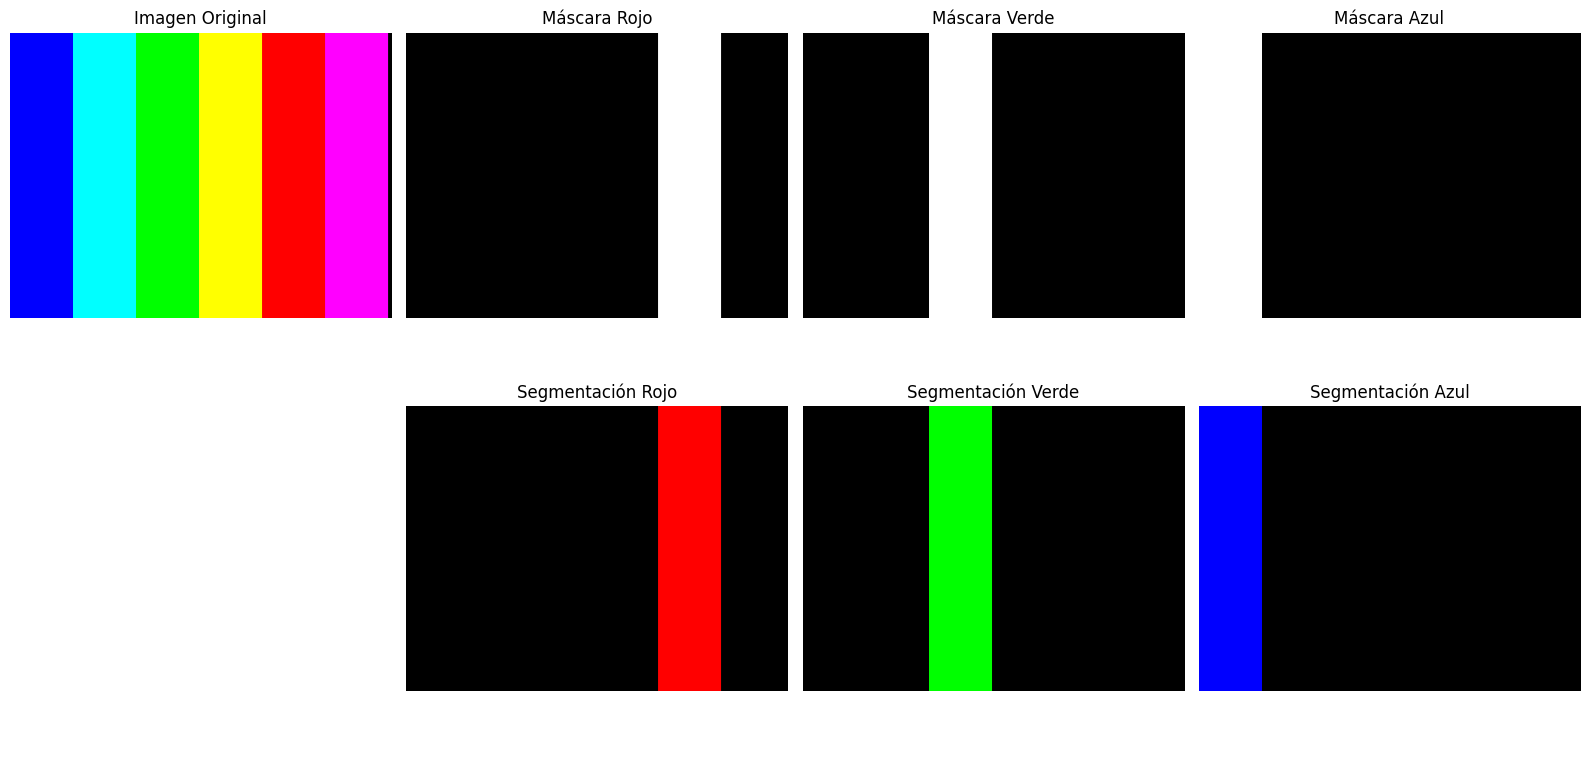

In [6]:
def segmentar_color_hsv(imagen, color_name, h_range, s_min=50, v_min=50):
    """Segmenta un color específico usando rangos HSV"""
    hsv = cv2.cvtColor(imagen, cv2.COLOR_RGB2HSV)
    
    # Crear máscara
    if len(h_range) == 2 and h_range[0] < h_range[1]:
        # Rango normal
        lower = np.array([h_range[0], s_min, v_min])
        upper = np.array([h_range[1], 255, 255])
        mask = cv2.inRange(hsv, lower, upper)
    else:
        # Rango que cruza 0° h_range[0] > h_range[1]
        # Crear dos máscaras: una para [0, h_range[1]] y otra para [h_range[0], 179]
        lower1 = np.array([0, s_min, v_min])
        upper1 = np.array([h_range[1], 255, 255])
        lower2 = np.array([h_range[0], s_min, v_min])
        upper2 = np.array([179, 255, 255])

        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        mask = cv2.bitwise_or(mask1, mask2)
    
    # Aplicar máscara
    resultado = cv2.bitwise_and(imagen, imagen, mask=mask)
    
    return mask, resultado

# Segmentar diferentes colores
mask_rojo, seg_rojo = segmentar_color_hsv(img_colores, "Rojo", [170, 10])
mask_verde, seg_verde = segmentar_color_hsv(img_colores, "Verde", [40, 80])
mask_azul, seg_azul = segmentar_color_hsv(img_colores, "Azul", [100, 130])

# Mostrar segmentación
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

axes[0,0].imshow(img_colores)
axes[0,0].set_title('Imagen Original')
axes[0,0].axis('off')

axes[0,1].imshow(mask_rojo, cmap='gray')
axes[0,1].set_title('Máscara Rojo')
axes[0,1].axis('off')

axes[0,2].imshow(mask_verde, cmap='gray')
axes[0,2].set_title('Máscara Verde')
axes[0,2].axis('off')

axes[0,3].imshow(mask_azul, cmap='gray')
axes[0,3].set_title('Máscara Azul')
axes[0,3].axis('off')

axes[1,0].axis('off')

axes[1,1].imshow(seg_rojo)
axes[1,1].set_title('Segmentación Rojo')
axes[1,1].axis('off')

axes[1,2].imshow(seg_verde)
axes[1,2].set_title('Segmentación Verde')
axes[1,2].axis('off')

axes[1,3].imshow(seg_azul)
axes[1,3].set_title('Segmentación Azul')
axes[1,3].axis('off')

plt.tight_layout()
plt.show()

## 3. Espacio de Color CIELAB (Lab)

### Características
- **L**: Lightness (luminosidad), rango 0-100
- **a**: Verde-Rojo, rango aproximado -128 a +127
- **b**: Azul-Amarillo, rango aproximado -128 a +127

CIELAB es el único espacio uniforme perceptualmente en nuestro análisis, lo que implica que permite mostrar las diferencias de colores percibidas por el ojo humano (ΔE).

### Experimento 1: Separación de Canales LAB

**Colores Saturados:** Utilizando esta imágen podemos ver como los colores rojo/verde muestran extremos del eje a*, azul/amarillo del eje b*

**Expectro completo:** Podremos ver cómo LAB maneja cambios graduales de color y cómo el canal L* separa claramente el brillo del color


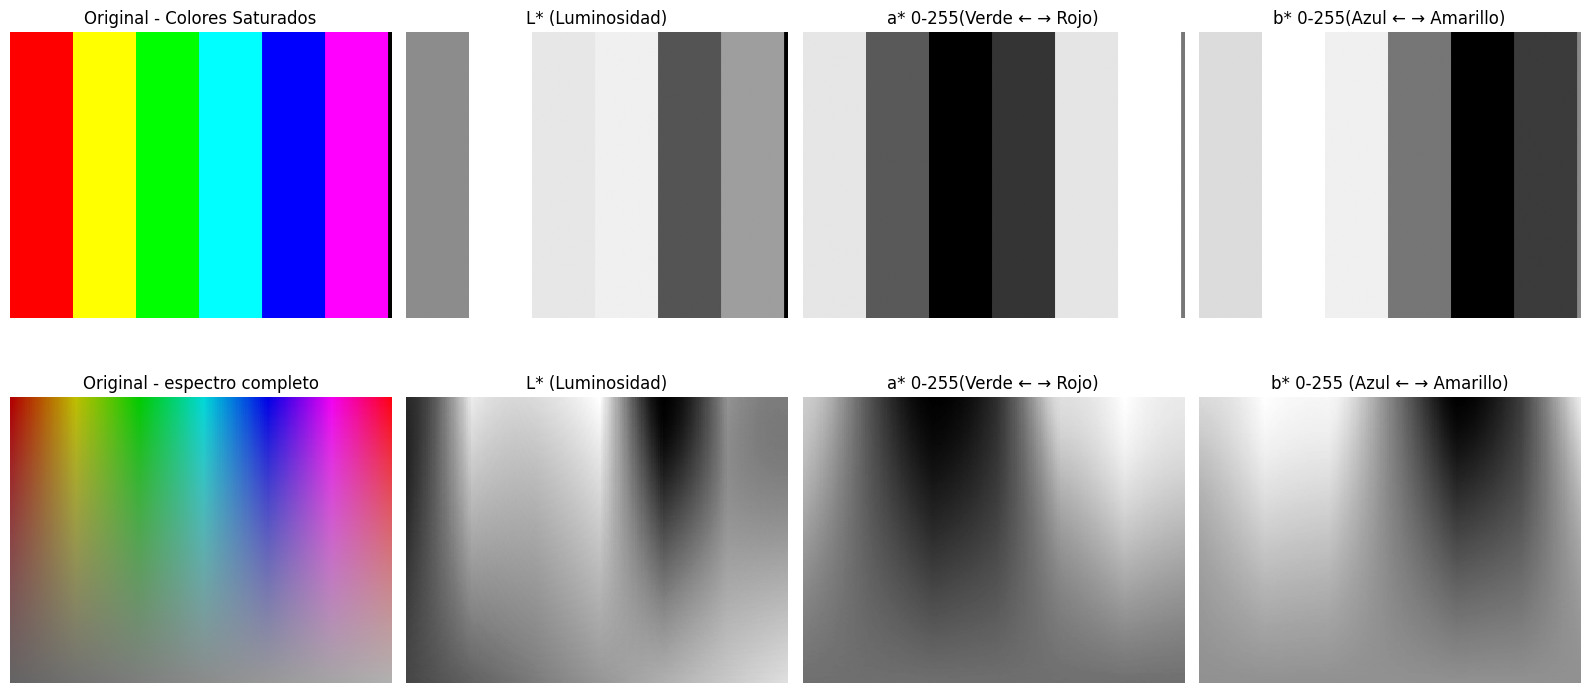

In [7]:
def analizar_lab(imagen):
    """Convierte imagen a LAB y analiza sus canales"""
    # Convertir de BGR a LAB
    lab = cv2.cvtColor(imagen, cv2.COLOR_BGR2LAB)
    
    # Separar canales
    l, a, b = cv2.split(lab)
    
    return lab, l, a, b

# Análisis LAB
lab_colores, l_col, a_col, b_col = analizar_lab(img_colores)
lab_gradiente, l_grad, a_grad, b_grad = analizar_lab(img_espectro_hsv)


# Visualizar análisis LAB
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Imagen de colores saturados
axes[0,0].imshow(cv2.cvtColor(img_colores, cv2.COLOR_BGR2RGB))
axes[0,0].set_title('Original - Colores Saturados')
axes[0,0].axis('off')

axes[0,1].imshow(l_col, cmap='gray')
axes[0,1].set_title('L* (Luminosidad)')
axes[0,1].axis('off')

axes[0,2].imshow(a_col, cmap='gray')  # Rojo-Verde
axes[0,2].set_title('a* 0-255(Verde ← → Rojo)')
axes[0,2].axis('off')

axes[0,3].imshow(b_col, cmap='gray')  # Amarillo-Azul
axes[0,3].set_title('b* 0-255(Azul ← → Amarillo)')
axes[0,3].axis('off')

# Imagen gradiente
axes[1,0].imshow(cv2.cvtColor(img_espectro_hsv, cv2.COLOR_BGR2RGB))
axes[1,0].set_title('Original - espectro completo')
axes[1,0].axis('off')

axes[1,1].imshow(l_grad, cmap='gray')
axes[1,1].set_title('L* (Luminosidad)')
axes[1,1].axis('off')

axes[1,2].imshow(a_grad, cmap='gray')
axes[1,2].set_title('a* 0-255(Verde ← → Rojo)')
axes[1,2].axis('off')

axes[1,3].imshow(b_grad, cmap='gray')
axes[1,3].set_title('b* 0-255 (Azul ← → Amarillo)')
axes[1,3].axis('off')

plt.tight_layout()
plt.show()


### Experimento 2: Cálculo de Delta E:

En este experimento veremos la poténcia de este espacio de colores para medir diferencias perceptuales entre colores de forma objetiva. Además, exploraremos otra capacidad muy potente de este espacio que es el de poder modificar la lumináncia de una imágen con facilidad. Para ello utilizaremos la imagen de los tonos de piel ya que es muy sensible a variaciones de luminancia (y además contiene colores vivos) y aumentaremos su lumináncia un 10% para medir perceptualmente el cambio de color que se obtiene.

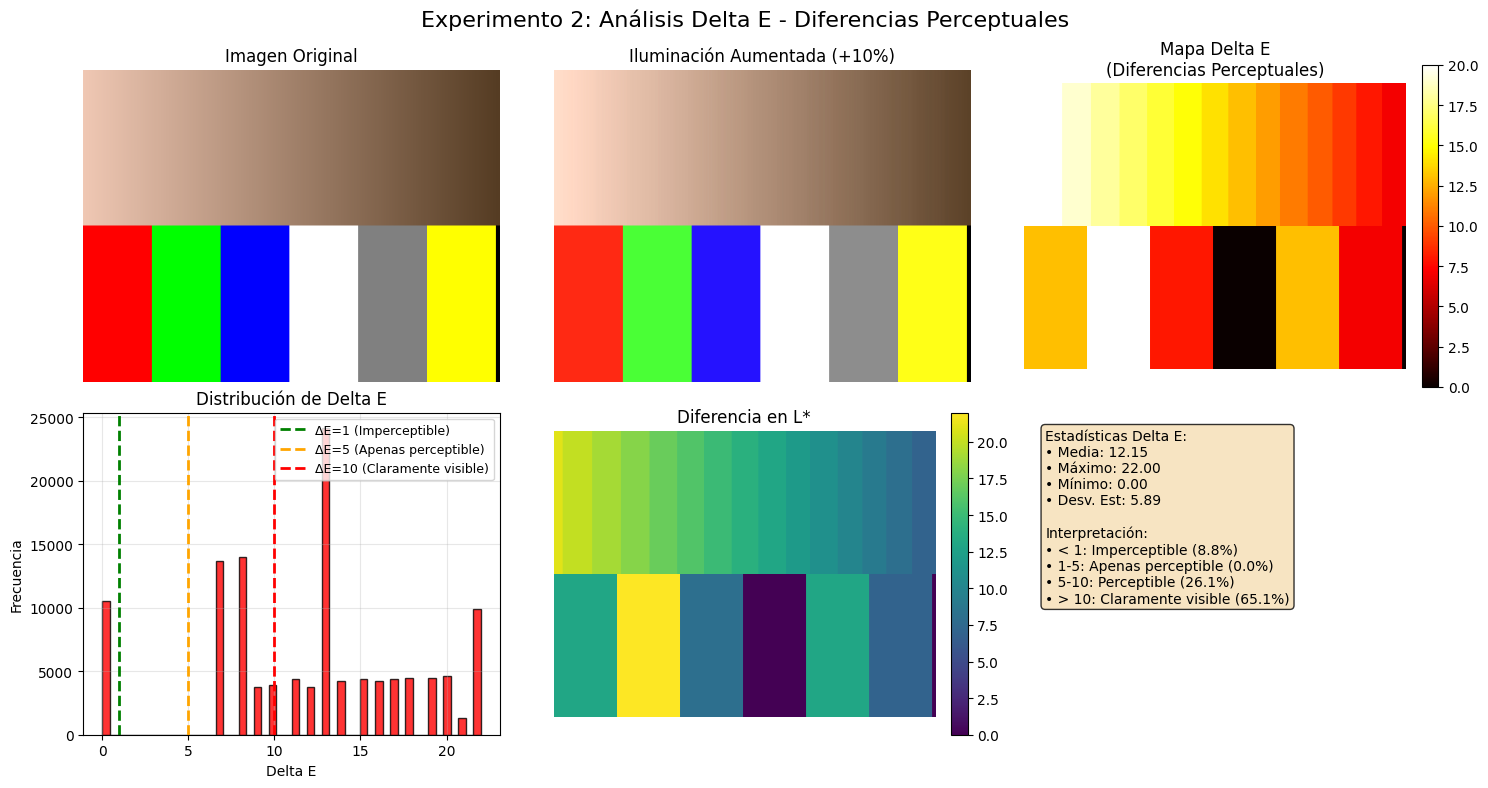

In [8]:

def simular_cambio_iluminacion(imagen, factor_luminancia=1.2):
    """Simula cambio de iluminación modificando el canal L* en LAB"""
    lab = cv2.cvtColor(imagen, cv2.COLOR_BGR2LAB)
    lab_modificada = lab.copy()
    
    # Modificar canal L* 
    lab_modificada[:,:,0] = np.clip(lab_modificada[:,:,0] * factor_luminancia, 0, 255)
    
    # Convertir de vuelta a BGR
    img_modificada = cv2.cvtColor(lab_modificada, cv2.COLOR_LAB2BGR)
    
    return img_modificada, lab, lab_modificada

def calcular_delta_e_avanzado(lab1, lab2):
    """Calcula Delta E entre dos imágenes LAB completas"""
    # Asegurar que son float64 para evitar overflow
    lab1 = lab1.astype(np.float64)
    lab2 = lab2.astype(np.float64)
    
    # Calcular diferencias en cada canal
    delta_l = lab1[:,:,0] - lab2[:,:,0]
    delta_a = lab1[:,:,1] - lab2[:,:,1] 
    delta_b = lab1[:,:,2] - lab2[:,:,2]
    
    # Calcular Delta E usando la fórmula CIE76
    delta_e = np.sqrt(delta_l**2 + delta_a**2 + delta_b**2)
    
    return delta_e, delta_l, delta_a, delta_b

# Simular cambio de iluminación en colores saturados
img_modificada, lab_original, lab_modificada = simular_cambio_iluminacion(img_piel, factor_luminancia=1.1)

# Calcular Delta E
delta_e, delta_l, delta_a, delta_b = calcular_delta_e_avanzado(lab_modificada, lab_original)

# Crear visualización enfocada en Delta E
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Fila 1: Comparación visual
axes[0,0].imshow(cv2.cvtColor(img_piel, cv2.COLOR_BGR2RGB)) 
axes[0,0].set_title('Imagen Original')
axes[0,0].axis('off')

axes[0,1].imshow(cv2.cvtColor(img_modificada, cv2.COLOR_BGR2RGB))
axes[0,1].set_title('Iluminación Aumentada (+10%)')
axes[0,1].axis('off')

# Mapa de calor Delta E (más prominente)
im1 = axes[0,2].imshow(delta_e, cmap='hot', vmin=0, vmax=20)
axes[0,2].set_title('Mapa Delta E\n(Diferencias Perceptuales)')
axes[0,2].axis('off')
plt.colorbar(im1, ax=axes[0,2], fraction=0.046, pad=0.04)

# Fila 2: Análisis Delta E
# Histograma de Delta E
axes[1,0].hist(delta_e.ravel(), bins=50, alpha=0.8, color='red', edgecolor='black')
axes[1,0].set_title('Distribución de Delta E')
axes[1,0].set_xlabel('Delta E')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].axvline(1, color='green', linestyle='--', linewidth=2, label='ΔE=1 (Imperceptible)')
axes[1,0].axvline(5, color='orange', linestyle='--', linewidth=2, label='ΔE=5 (Apenas perceptible)')
axes[1,0].axvline(10, color='red', linestyle='--', linewidth=2, label='ΔE=10 (Claramente visible)')
axes[1,0].legend(fontsize=9)
axes[1,0].grid(True, alpha=0.3)

# Solo diferencia de luminancia 
diferencia_lum = np.abs(delta_l)
im2 = axes[1,1].imshow(diferencia_lum, cmap='viridis')
axes[1,1].set_title('Diferencia en L*')
axes[1,1].axis('off')
plt.colorbar(im2, ax=axes[1,1], fraction=0.046, pad=0.04)

# Estadísticas Delta E
stats_text = f"""Estadísticas Delta E:
• Media: {np.mean(delta_e):.2f}
• Máximo: {np.max(delta_e):.2f}
• Mínimo: {np.min(delta_e):.2f}
• Desv. Est: {np.std(delta_e):.2f}

Interpretación:
• < 1: Imperceptible ({np.sum(delta_e < 1)/delta_e.size*100:.1f}%)
• 1-5: Apenas perceptible ({np.sum((delta_e >= 1) & (delta_e < 5))/delta_e.size*100:.1f}%)
• 5-10: Perceptible ({np.sum((delta_e >= 5) & (delta_e < 10))/delta_e.size*100:.1f}%)
• > 10: Claramente visible ({np.sum(delta_e >= 10)/delta_e.size*100:.1f}%)"""

axes[1,2].text(0.05, 0.95, stats_text, transform=axes[1,2].transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
axes[1,2].axis('off')

plt.suptitle('Experimento 2: Análisis Delta E - Diferencias Perceptuales', fontsize=16)
plt.tight_layout()
plt.show()

## 4. Espacio de Color YCrCb

### Características
- **Y**: Luminancia (información de brillo), rango 0-255
- **Cr**: Chrominance Red-difference (Rojo - Y), rango 0-255
- **Cb**: Chrominance Blue-difference (Azul - Y), rango 0-255

YCrCb es fundamental en visión por ordenador por dos razones principales:
- Permite procesar brillo independientemente del color
- Los canales Cr-Cb forman clusters brillantemente definidos para tonos de piel humana por lo que facilitan la detección de piel

### Experimento 1: Separación de Canales YCrCb

Para este experimento utilizaremos la imagen de tonos de piel porque:
- Los colores puros que contiene la imagen permiten ver cómo YCrCb descompone color vs luminancia
- Podremos hacer una comparativa directa del comportamiento de estos colores con los tonos de piel

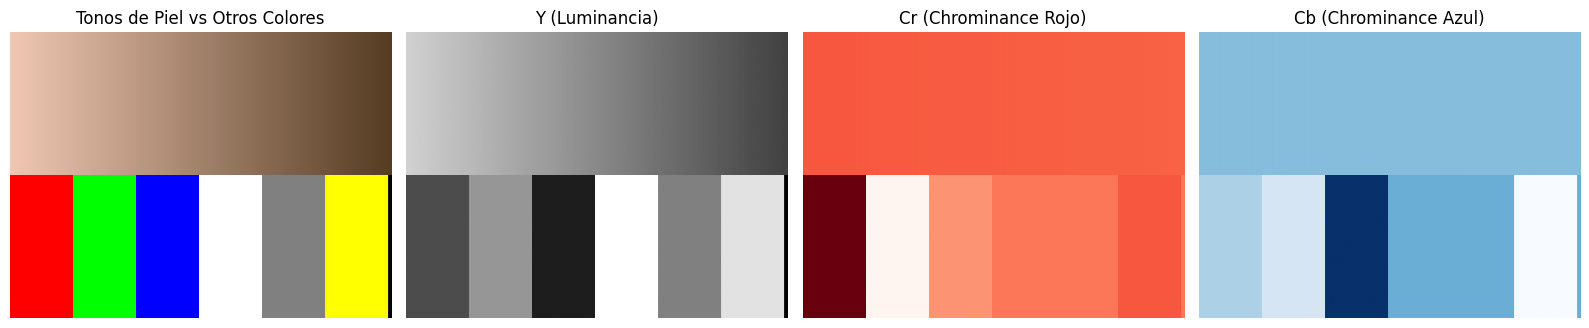

In [9]:
def analizar_ycrcb(imagen):
    """Convierte imagen a YCrCb y analiza sus canales"""
    # Convertir de RGB a YCrCb
    ycrcb = cv2.cvtColor(imagen, cv2.COLOR_BGR2YCrCb)
    
    # Separar canales
    y, cr, cb = cv2.split(ycrcb)
    
    return ycrcb, y, cr, cb

ycrcb_piel, y_piel, cr_piel, cb_piel = analizar_ycrcb(img_piel)

# Visualizar análisis YCrCb
fig, axes = plt.subplots(1, 4, figsize=(16, 8))

# Imagen con tonos de piel
axes[0].imshow(cv2.cvtColor(img_piel, cv2.COLOR_BGR2RGB))
axes[0].set_title('Tonos de Piel vs Otros Colores')
axes[0].axis('off')

axes[1].imshow(y_piel, cmap='gray')
axes[1].set_title('Y (Luminancia)')
axes[1].axis('off')

axes[2].imshow(cr_piel, cmap='Reds')
axes[2].set_title('Cr (Chrominance Rojo)')
axes[2].axis('off')

axes[3].imshow(cb_piel, cmap='Blues')
axes[3].set_title('Cb (Chrominance Azul)')
axes[3].axis('off')

plt.tight_layout()
plt.show()


### Experimento 2: Detección de Tonos de Piel

YCrCb se utiliza sobretodo por su gran rendimiento a la hora de detectar los tonos de colores correspondientes a la piel humana. En este experimento trataremos de detectar la sección que se corresponde con los tonos de piel de la imagen y veremos cual es la destribución típica de la crominancia para los tonos azules y rojos en la región de los colores de la piel.

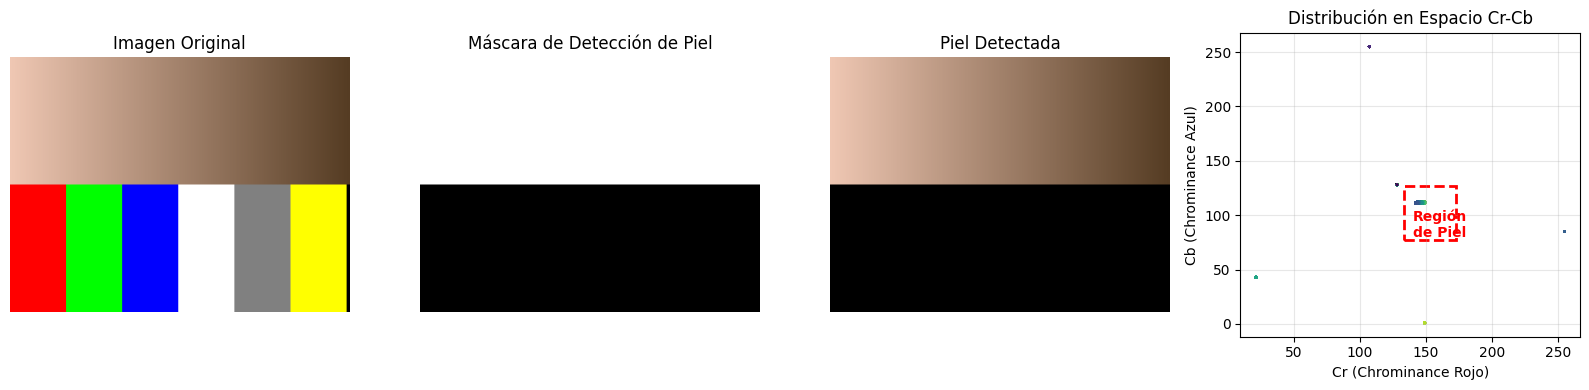

In [10]:

def detectar_piel_ycrcb(imagen):
    """Detecta tonos de piel usando rangos típicos en YCrCb"""
    ycrcb = cv2.cvtColor(imagen, cv2.COLOR_BGR2YCrCb)
    
    # Rangos típicos para detección de piel en YCrCb
    lower_skin = np.array([0, 133, 77])    # Límites inferiores
    upper_skin = np.array([255, 173, 127]) # Límites superiores
    
    # Crear máscara
    mask = cv2.inRange(ycrcb, lower_skin, upper_skin)
    
    # Aplicar máscara
    resultado = cv2.bitwise_and(imagen, imagen, mask=mask)
    
    return mask, resultado

# Detectar piel
mask_piel, det_piel = detectar_piel_ycrcb(img_piel)

# Análisis en espacio Cr-Cb
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(cv2.cvtColor(img_piel, cv2.COLOR_BGR2RGB))
axes[0].set_title('Imagen Original')
axes[0].axis('off')

axes[1].imshow(mask_piel, cmap='gray')
axes[1].set_title('Máscara de Detección de Piel')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(det_piel, cv2.COLOR_BGR2RGB))
axes[2].set_title('Piel Detectada')
axes[2].axis('off')

# Scatter plot en espacio Cr-Cb
axes[3].scatter(cr_piel.ravel(), cb_piel.ravel(), c=y_piel.ravel(), 
               cmap='viridis', alpha=0.6, s=1)
axes[3].set_xlabel('Cr (Chrominance Rojo)')
axes[3].set_ylabel('Cb (Chrominance Azul)')
axes[3].set_title('Distribución en Espacio Cr-Cb')
axes[3].grid(True, alpha=0.3)

# Dibujar región típica de piel
rect = Rectangle((133, 77), 173-133, 127-77, linewidth=2, 
                edgecolor='red', facecolor='none', linestyle='--')
axes[3].add_patch(rect)
axes[3].text(140, 80, 'Región\nde Piel', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Escala de Grises y Aplicaciones Binarias

### Características
- Sólo utiliza un canal con valores de intensidad 0-255
- Reduce la dimensionalidad de 3 canales (RGB) a 1 y manteniendo las formas y texturas
- Procesamiento más rápido

### Experimento 1: Diferentes conversiones a escala de grises
En este experimento exploraremos varios de los diferentes métodos de conversión a escala de grises:
1. **Promedio**: (R + G + B) / 3
2. **Luminancia (ITU-R BT.709)**: 0.299R + 0.587G + 0.114B
3. **Desaturación**: (max(R,G,B) + min(R,G,B)) / 2
4. **Canal único**: Usar solo R, G, o B

Para poder observar con mayor claridad los resultados utilizaremos la imagen de colores saturados

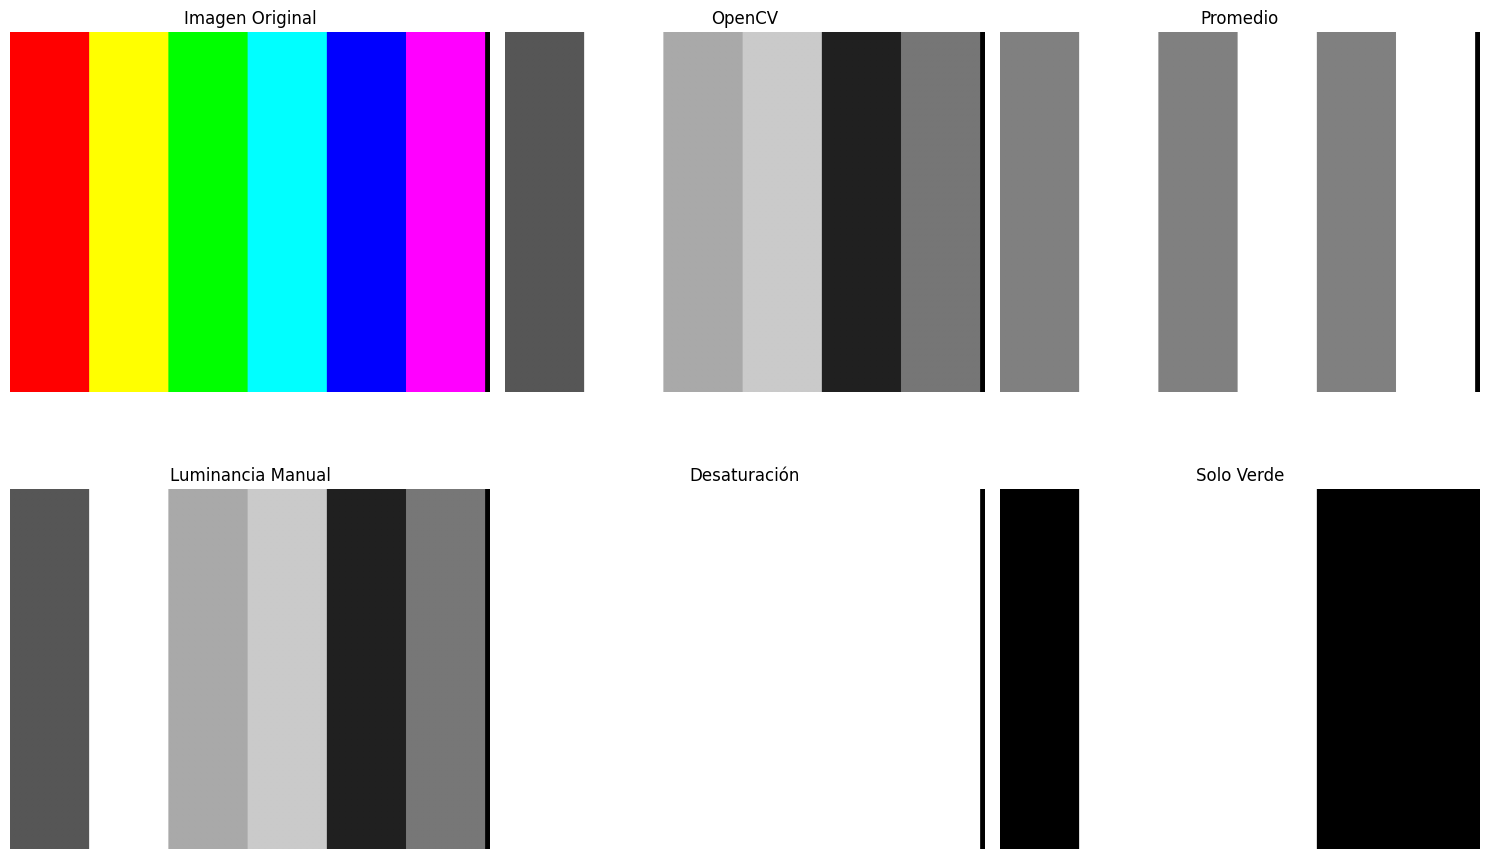

In [11]:
def convertir_gris_metodos(imagen):
    """Compara diferentes métodos de conversión a escala de grises"""
    # Método 1: Conversión estándar de OpenCV 
    gris_opencv = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Método 2: Promedio simple
    gris_promedio = np.mean(imagen, axis=2).astype(np.uint8)
    
    # Método 3: Luminancia manual 
    b, g, r = cv2.split(imagen)
    gris_luminancia = (0.114 * b + 0.587 * g + 0.299 * r).astype(np.uint8)
    
    # Método 4: Desaturación
    gris_desaturacion = ((np.max(imagen, axis=2) + np.min(imagen, axis=2)) / 2).astype(np.uint8)
    
    # Método 5: Solo canal verde (más sensible a luminancia)
    gris_verde = imagen[:,:,1]
    
    return gris_opencv, gris_promedio, gris_luminancia, gris_desaturacion, gris_verde

# Analizar diferentes métodos de conversión
metodos = convertir_gris_metodos(img_colores)
nombres_metodos = ['OpenCV', 'Promedio', 'Luminancia Manual', 'Desaturación', 'Solo Verde']

# Visualizar comparación de métodos
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Imagen original
axes[0,0].imshow(cv2.cvtColor(img_colores, cv2.COLOR_BGR2RGB))
axes[0,0].set_title('Imagen Original')
axes[0,0].axis('off')

# Métodos de conversión
for i, (metodo, nombre) in enumerate(zip(metodos, nombres_metodos)):
    fila = (i + 1) // 3
    col = (i + 1) % 3
    axes[fila, col].imshow(metodo, cmap='gray')
    axes[fila, col].set_title(nombre)
    axes[fila, col].axis('off')

plt.tight_layout()
plt.show()

### Experimento 2: Umbralización de Formas Geométricas

En este experimento analizaremos diferentes técnicas de umbralización aplicadas a formas geométricas. La umbralización es fundamental para convertir imágenes en escala de grises a imágenes binarias, separando objetos del fondo.

Utilizaremos la imagen de formas geométricas porque contiene formas claramente definidas con diferentes colores y contrastes y el fondo blanco proporciona un buen contraste para la binarización

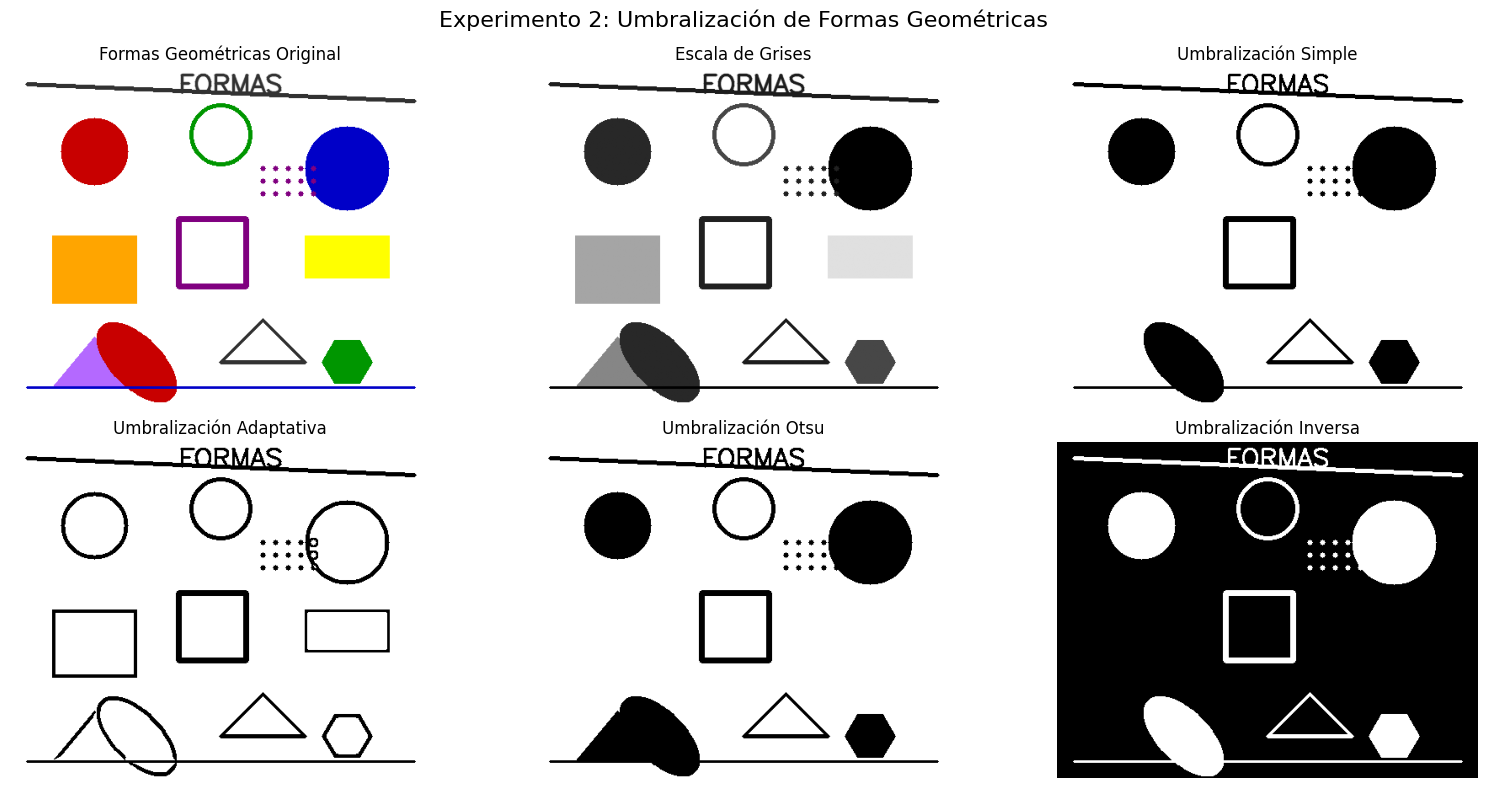

In [12]:
def procesar_formas_geometricas(imagen_formas):
    """Demuestra el procesamiento de formas geométricas con umbralización"""
    # Convertir a escala de grises
    gris = cv2.cvtColor(imagen_formas, cv2.COLOR_BGR2GRAY)
    
    # Umbralización simple
    _, binario_simple = cv2.threshold(gris, 127, 255, cv2.THRESH_BINARY)
    
    # Umbralización adaptativa
    binario_adaptativo = cv2.adaptiveThreshold(gris, 255, 
                                             cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                             cv2.THRESH_BINARY, 11, 2)
    
    # Umbralización de Otsu
    _, binario_otsu = cv2.threshold(gris, 0, 255, 
                                   cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Umbralización inversa (para mejor visualización con fondo blanco)
    _, binario_inverso = cv2.threshold(gris, 127, 255, cv2.THRESH_BINARY_INV)
    
    return gris, binario_simple, binario_adaptativo, binario_otsu, binario_inverso

# Procesar imagen de formas geométricas
gris_formas, bin_simple, bin_adaptativo, bin_otsu, bin_inverso = procesar_formas_geometricas(img_formas)

# Visualizar análisis de formas geométricas
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Imagen original en color
axes[0,0].imshow(cv2.cvtColor(img_formas, cv2.COLOR_BGR2RGB))
axes[0,0].set_title('Formas Geométricas Original')
axes[0,0].axis('off')

# Imagen en escala de grises
axes[0,1].imshow(gris_formas, cmap='gray')
axes[0,1].set_title('Escala de Grises')
axes[0,1].axis('off')

# Umbralización simple
axes[0,2].imshow(bin_simple, cmap='gray')
axes[0,2].set_title('Umbralización Simple')
axes[0,2].axis('off')

# Umbralización adaptativa
axes[1,0].imshow(bin_adaptativo, cmap='gray')
axes[1,0].set_title('Umbralización Adaptativa')
axes[1,0].axis('off')

# Umbralización de Otsu
axes[1,1].imshow(bin_otsu, cmap='gray')
axes[1,1].set_title('Umbralización Otsu')
axes[1,1].axis('off')

# Umbralización inversa
axes[1,2].imshow(bin_inverso, cmap='gray')
axes[1,2].set_title('Umbralización Inversa')
axes[1,2].axis('off')

plt.suptitle('Experimento 2: Umbralización de Formas Geométricas', fontsize=16)
plt.tight_layout()
plt.show()


### Experimento 3: Detección de bordes
En este experimento exploraremos los algoritmos de detección de bordes de Canny, Sobel y el Laplaciano utilizando la imagen que presenta diferentes formas geométricas de diferentes colores.

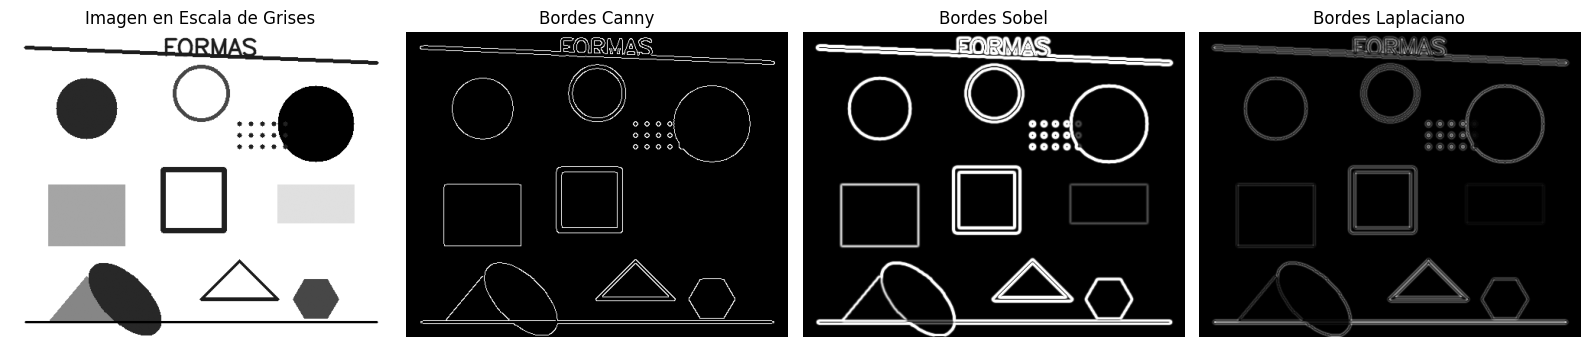

In [13]:
def detectar_bordes(imagen_gris):
    """Diferentes algoritmos de detección de bordes"""
    # Suavizar imagen para reducir ruido
    suavizada = cv2.GaussianBlur(imagen_gris, (5, 5), 0)
    
    # Canny
    bordes_canny = cv2.Canny(suavizada, 50, 150)
    
    # Sobel
    sobel_x = cv2.Sobel(suavizada, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(suavizada, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_combined = np.uint8(np.clip(sobel_combined, 0, 255))
    
    # Laplaciano
    laplaciano = cv2.Laplacian(suavizada, cv2.CV_64F)
    laplaciano = np.uint8(np.clip(np.abs(laplaciano), 0, 255))
    
    return bordes_canny, sobel_combined, laplaciano

# Convertir imagen de colores a escala de grises para detección de bordes
gris_para_bordes = cv2.cvtColor(img_formas, cv2.COLOR_BGR2GRAY)
canny, sobel, laplaciano = detectar_bordes(gris_para_bordes)

# Visualizar detección de bordes
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(gris_para_bordes, cmap='gray')
axes[0].set_title('Imagen en Escala de Grises')
axes[0].axis('off')

axes[1].imshow(canny, cmap='gray')
axes[1].set_title('Bordes Canny')
axes[1].axis('off')

axes[2].imshow(sobel, cmap='gray')
axes[2].set_title('Bordes Sobel')
axes[2].axis('off')

axes[3].imshow(laplaciano, cmap='gray')
axes[3].set_title('Bordes Laplaciano')
axes[3].axis('off')

plt.tight_layout()
plt.show()


## 6. Espacio de Color XYZ (CIE 1931)

### Características
- **X**: Componente tricromática roja (mezcla de conos L y M), rango 0-95.047
- **Y**: Componente tricromática verde (luminancia), rango 0-100.000
- **Z**: Componente tricromática azul (cono S), rango 0-108.883
- Es el estándar que sirve de base matemática para todos los demás espacios
- Basado en el observador estándar CIE

### Experimento 1. Separación de Canales XYZ

Para este experimento utilizaremos:

1. **Colores saturados**: Permite observar cómo XYZ descompone los colores primarios
   - **Canal X**: Dominante en rojos y magentas
   - **Canal Y**: Representa la luminancia (similar a L* en LAB)
   - **Canal Z**: Dominante en azules y cianes

2. **Espectro HSV completo**: Muestra la distribución XYZ en todo el espacio cromático
   - **Variación completa**: Permite ver cómo XYZ maneja diferentes combinaciones H-S-V
   - **Análisis de luminancia**: El canal Y debe correlacionar con la percepción de brillo
   - **Comparación con LAB**: Permite comparar Y con L* para validar la conversión

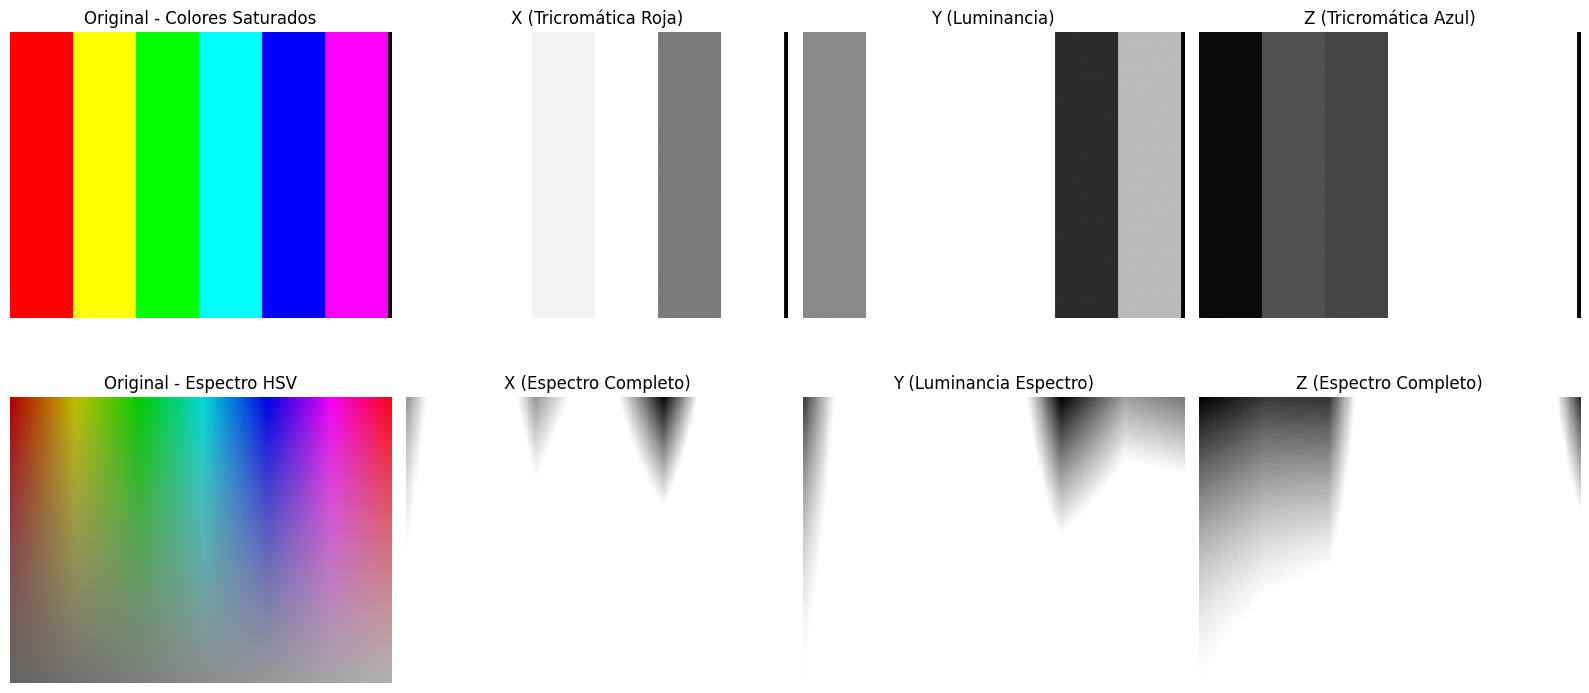

In [14]:
def analizar_xyz(imagen):
    """Convierte imagen a XYZ y analiza sus canales"""
    # Convertir de BGR a XYZ
    xyz = cv2.cvtColor(imagen, cv2.COLOR_BGR2XYZ)
    
    # Separar canales
    x, y, z = cv2.split(xyz)
    
    return xyz, x, y, z

def normalizar_canal_xyz(canal, factor_normalizacion):
    """Normaliza un canal XYZ para visualización (0-255)"""
    canal_norm = (canal.astype(np.float32) / factor_normalizacion * 255)
    return np.clip(canal_norm, 0, 255).astype(np.uint8)

# Análisis XYZ usando colores saturados y espectro HSV
xyz_colores, x_col, y_col, z_col = analizar_xyz(img_colores)
xyz_gradiente, x_grad, y_grad, z_grad = analizar_xyz(img_espectro_hsv)

# Factores de normalización basados en el iluminante D65
x_col_norm = normalizar_canal_xyz(x_col, 95.047)
y_col_norm = normalizar_canal_xyz(y_col, 100.000)
z_col_norm = normalizar_canal_xyz(z_col, 108.883)

x_grad_norm = normalizar_canal_xyz(x_grad, 95.047)
y_grad_norm = normalizar_canal_xyz(y_grad, 100.000)
z_grad_norm = normalizar_canal_xyz(z_grad, 108.883)

# Visualizar análisis XYZ
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Imagen de colores saturados
axes[0,0].imshow(cv2.cvtColor(img_colores, cv2.COLOR_BGR2RGB))
axes[0,0].set_title('Original - Colores Saturados')
axes[0,0].axis('off')

axes[0,1].imshow(x_col_norm, cmap='gray')
axes[0,1].set_title('X (Tricromática Roja)')
axes[0,1].axis('off')

axes[0,2].imshow(y_col_norm, cmap='gray')
axes[0,2].set_title('Y (Luminancia)')
axes[0,2].axis('off')

axes[0,3].imshow(z_col_norm, cmap='gray')
axes[0,3].set_title('Z (Tricromática Azul)')
axes[0,3].axis('off')

# Espectro HSV completo
axes[1,0].imshow(cv2.cvtColor(img_espectro_hsv, cv2.COLOR_BGR2RGB))
axes[1,0].set_title('Original - Espectro HSV')
axes[1,0].axis('off')

axes[1,1].imshow(x_grad_norm, cmap='gray')
axes[1,1].set_title('X (Espectro Completo)')
axes[1,1].axis('off')

axes[1,2].imshow(y_grad_norm, cmap='gray')
axes[1,2].set_title('Y (Luminancia Espectro)')
axes[1,2].axis('off')

axes[1,3].imshow(z_grad_norm, cmap='gray')
axes[1,3].set_title('Z (Espectro Completo)')
axes[1,3].axis('off')

plt.tight_layout()
plt.show()

### Experimento 2: Luminancia Lineal vs Luminancia Perceptual

Este experimento explora la distinción entre **luminancia lineal** y **luminancia perceptual**.

La Luminancia Lineal (Canal Y de XYZ) representa la intensidad física de luz emitida o reflejada y es proporcional a la radiancia medida por sensores físicos.
Es fundamental para cálculos físicos como balance de blancos, calibración de cámaras...

Por otro lado, la Luminancia Perceptual (Canal L* de CIELAB) representa cómo el ojo humano percibe el brillo y es esencial para aplicaciones visuales como edición de imágenes, interfaces...

Compararemos el canal Y (XYZ) con L* (LAB) usando dos imágenes:
- **Tonos de piel**: Muy sensibles a variaciones de luminancia, críticos en aplicaciones de visión por ordenador
- **Espectro HSV**: Amplio rango cromático para análisis estadístico robusto

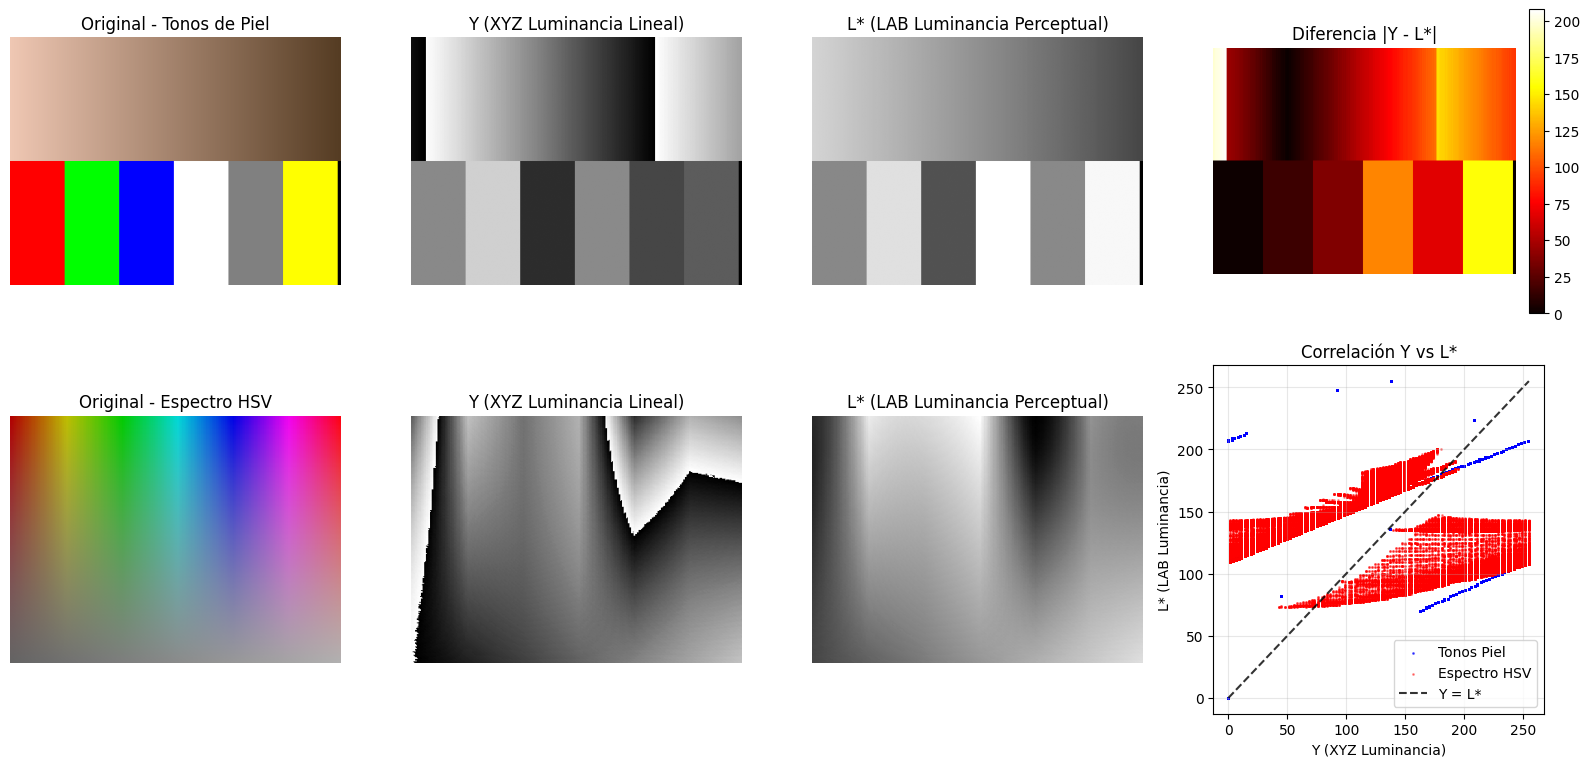

In [15]:
def comparar_luminancias_xyz_lab(imagen):
    """Compara el canal Y de XYZ con el canal L* de LAB"""
    # Convertir a XYZ
    xyz = cv2.cvtColor(imagen, cv2.COLOR_BGR2XYZ)
    y_xyz = xyz[:,:,1]  # Canal Y (luminancia lineal)
    
    # Convertir a LAB
    lab = cv2.cvtColor(imagen, cv2.COLOR_BGR2LAB)
    l_lab = lab[:,:,0]  # Canal L* (luminancia perceptual)
    
    # Normalizar Y de XYZ para comparación visual
    y_xyz_norm = (y_xyz / 100.0 * 255).astype(np.uint8)
    
    return y_xyz, l_lab, y_xyz_norm, xyz, lab

# Comparar luminancias usando tonos de piel e espectro HSV
y_piel, l_piel, y_piel_norm, xyz_piel, lab_piel = comparar_luminancias_xyz_lab(img_piel)
y_espectro, l_espectro, y_espectro_norm, xyz_espectro, lab_espectro = comparar_luminancias_xyz_lab(img_espectro_hsv)

# Visualizar comparación de luminancias
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Fila 1: Tonos de piel
axes[0,0].imshow(cv2.cvtColor(img_piel, cv2.COLOR_BGR2RGB))
axes[0,0].set_title('Original - Tonos de Piel')
axes[0,0].axis('off')

axes[0,1].imshow(y_piel_norm, cmap='gray')
axes[0,1].set_title('Y (XYZ Luminancia Lineal)')
axes[0,1].axis('off')

axes[0,2].imshow(l_piel, cmap='gray')
axes[0,2].set_title('L* (LAB Luminancia Perceptual)')
axes[0,2].axis('off')

# Diferencia entre luminancias
diff_piel = np.abs(y_piel_norm.astype(np.float32) - l_piel.astype(np.float32))
im1 = axes[0,3].imshow(diff_piel, cmap='hot')
axes[0,3].set_title('Diferencia |Y - L*|')
axes[0,3].axis('off')
plt.colorbar(im1, ax=axes[0,3], fraction=0.046, pad=0.04)

# Fila 2: Espectro HSV
axes[1,0].imshow(cv2.cvtColor(img_espectro_hsv, cv2.COLOR_BGR2RGB))
axes[1,0].set_title('Original - Espectro HSV')
axes[1,0].axis('off')

axes[1,1].imshow(y_espectro_norm, cmap='gray')
axes[1,1].set_title('Y (XYZ Luminancia Lineal)')
axes[1,1].axis('off')

axes[1,2].imshow(l_espectro, cmap='gray')
axes[1,2].set_title('L* (LAB Luminancia Perceptual)')
axes[1,2].axis('off')

# Scatter plot Y vs L*
axes[1,3].scatter(y_piel_norm.ravel(), l_piel.ravel(), alpha=0.6, s=1, c='blue', label='Tonos Piel')
axes[1,3].scatter(y_espectro_norm.ravel(), l_espectro.ravel(), alpha=0.4, s=1, c='red', label='Espectro HSV')
axes[1,3].plot([0, 255], [0, 255], 'k--', alpha=0.8, label='Y = L*')
axes[1,3].set_xlabel('Y (XYZ Luminancia)')
axes[1,3].set_ylabel('L* (LAB Luminancia)')
axes[1,3].set_title('Correlación Y vs L*')
axes[1,3].legend()
axes[1,3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()